Step 1: install necessary libraries

In [ ]:
!pip install transformers
!pip install torch
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install imbalanced-learn

Step 2: Load and Preprocess the Dataset

In [ ]:
#Load and Preprocess the Dataset
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Load dataset
file_path = './eng.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError("Train file not found!")

train_data = pd.read_csv(file_path)

if train_data.empty:
    raise ValueError("Train dataset is empty!")

# Preprocessing
def preprocess_data(data):
    data['text'] = data['text'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()
    # Fill empty text with placeholders
    data['text'] = data['text'].fillna("unknown")
    # Ensure label columns have at least one positive value
    data = data[(data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']] > 0).any(axis=1)]
    return data

train_data = preprocess_data(train_data)

# Train-validation split
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
X_train, y_train = train_data['text'].tolist(), train_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values
X_val, y_val = val_data['text'].tolist(), val_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values

# Resampling for Balance (Anger Only)
augmented_data = pd.DataFrame({
    'text': X_train,
    **{label: y_train[:, i] for i, label in enumerate(['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])}
})

minority_anger = augmented_data[augmented_data['Anger'] == 1]
majority_anger = augmented_data[augmented_data['Anger'] == 0]

# Oversample minority class for Anger
resampled_minority_anger = resample(
    minority_anger,
    replace=True,
    n_samples=len(majority_anger),
    random_state=42
)

# Combine the resampled Anger data
balanced_anger_data = pd.concat([majority_anger, resampled_minority_anger])

# Keep the other labels as is
balanced_data = balanced_anger_data.copy()

# Final resampled training data
X_train_resampled = balanced_data['text'].tolist()
y_train_resampled = balanced_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values


Step 3: Tokenization and data preparation

In [ ]:
# Tokenization
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

def tokenize_and_encode(text_list):
    return tokenizer(
        text_list,
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )

# Tokenization
X_train_encoded = tokenize_and_encode(X_train_resampled)
X_val_encoded = tokenize_and_encode(X_val)

# Dataset Preparation
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(
    X_train_encoded['input_ids'], X_train_encoded['attention_mask'], torch.tensor(y_train_resampled, dtype=torch.float32)
)
val_dataset = TensorDataset(
    X_val_encoded['input_ids'], X_val_encoded['attention_mask'], torch.tensor(y_val, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

step 4: model definition and training

In [ ]:
# Model Definition
from transformers import XLMRobertaForSequenceClassification
import torch.nn as nn

class EmotionClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.roberta = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=num_labels)
        self.dropout = nn.Dropout(0.4)  # Increased dropout for better regularization

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return self.dropout(outputs.logits)

model = EmotionClassifier(num_labels=5).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Fine-tune all layers
for param in model.roberta.parameters():
    param.requires_grad = True

# Training Setup
import torch.optim as optim
from torch.amp import GradScaler, autocast
from transformers import get_scheduler

# Adjusted learning rate and weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * len(train_loader)),  # Increased warm-up steps
    num_training_steps=len(train_loader) * 7
)

# Adjusted loss function with class weights
class_weights = torch.tensor([2.0, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=7, patience=4):
    scaler = GradScaler("cuda")
    train_losses, val_losses = [], []
    best_val_loss, wait = float('inf'), 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            input_ids, attention_mask, labels = (b.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for b in batch)
            optimizer.zero_grad()

            with autocast("cuda"):
                logits = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = (b.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for b in batch)

                with autocast("cuda"):
                    logits = model(input_ids=input_ids, attention_mask=attention_mask)
                    val_loss = criterion(logits, labels)
                    total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pt")
            print(f"Model saved to: {os.path.abspath('best_model.pt')}")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=7, patience=4)


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7, Train Loss: 0.7416, Val Loss: 0.6999
Model saved to: /content/best_model.pt
Epoch 2/7, Train Loss: 0.7071, Val Loss: 0.6829
Model saved to: /content/best_model.pt
Epoch 3/7, Train Loss: 0.6816, Val Loss: 0.6227
Model saved to: /content/best_model.pt
Epoch 4/7, Train Loss: 0.6218, Val Loss: 0.5347
Model saved to: /content/best_model.pt
Epoch 5/7, Train Loss: 0.5825, Val Loss: 0.5144
Model saved to: /content/best_model.pt
Epoch 6/7, Train Loss: 0.5635, Val Loss: 0.4897
Model saved to: /content/best_model.pt
Epoch 7/7, Train Loss: 0.5550, Val Loss: 0.4911


Step 5: Performance Evaluations

In [ ]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

def evaluate_with_confusion_matrix(model, data_loader):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = (b.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for b in batch)
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(logits).cpu().numpy()

            thresholds = [0.4, 0.6, 0.5, 0.5, 0.5]
            preds = (preds > np.array(thresholds)).astype(int)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    y_true = np.concatenate(all_labels, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)

    print(f"Classification Report:\n{classification_report(y_true, y_pred, target_names=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'], zero_division=1)}")

    macro_f1 = f1_score(y_true, y_pred, average="macro")
    print(f"Macro F1 Score: {macro_f1:.4f}")

    conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    print(f"Confusion Matrix:\n{conf_matrix}")

    return macro_f1

# Load Best Model
model.load_state_dict(torch.load("best_model.pt"))

# Evaluate on Train Set
print("Evaluating on Train Set...")
train_macro_f1 = evaluate_with_confusion_matrix(model, train_loader)
print(f"Train Set Macro F1 Score: {train_macro_f1:.4f}")

# Evaluate on Validation Set
print("Evaluating on Validation Set...")
val_macro_f1 = evaluate_with_confusion_matrix(model, val_loader)
print(f"Validation Set Macro F1 Score: {val_macro_f1:.4f}")


<ipython-input-4-98cc3aa44453>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


Evaluating on Train Set...
Classification Report:
              precision    recall  f1-score   support

       Anger       0.82      0.98      0.89      1756
        Fear       0.88      0.85      0.86      2389
         Joy       0.80      0.68      0.74       601
     Sadness       0.73      0.74      0.73      1397
    Surprise       0.77      0.62      0.69      1185

   micro avg       0.81      0.81      0.81      7328
   macro avg       0.80      0.77      0.78      7328
weighted avg       0.81      0.81      0.81      7328
 samples avg       0.82      0.81      0.78      7328

Macro F1 Score: 0.7825
Confusion Matrix:
[[1734   13    9    0    0]
 [ 322  673   96    2   15]
 [  68   29  352    6    5]
 [  48   35   10    8    3]
 [  23   32   19    0   10]]
Train Set Macro F1 Score: 0.7825
Evaluating on Validation Set...
Classification Report:
              precision    recall  f1-score   support

       Anger       0.31      0.83      0.45        66
        Fear       0.81     

Step 6: plot

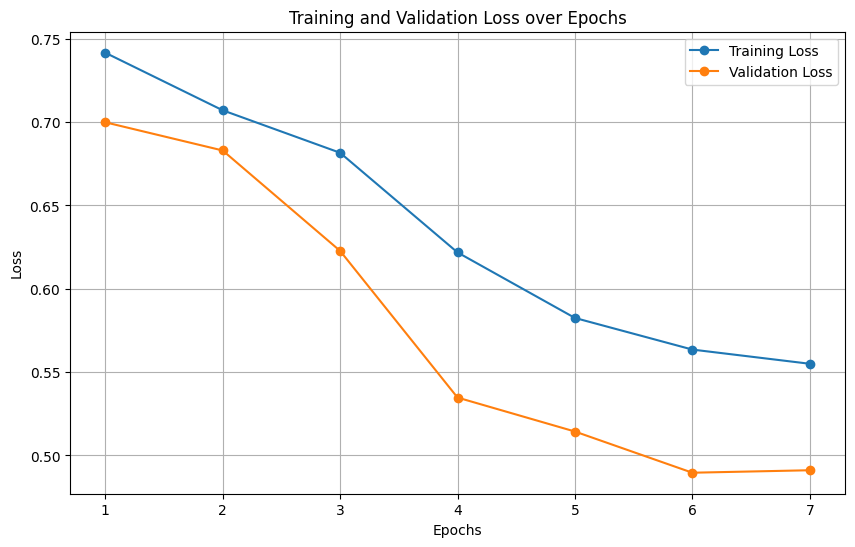

In [ ]:
import matplotlib.pyplot as plt  # Import matplotlib.pyplot

# Plotting the loss curves
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the losses
plot_loss(train_losses, val_losses)



Step 7: visulization of predicted values

In [ ]:
#Visualize Predictions and True Labels
import pandas as pd
import torch
import numpy as np

# Define emotion labels
emotion_labels = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

# Helper function to decode predictions
def decode_predictions(predictions):
    decoded_preds = []
    for pred in predictions:
        decoded_preds.append([emotion_labels[i] for i, val in enumerate(pred) if val == 1])
    return decoded_preds

# Helper function to decode true labels
def decode_true_labels(labels):
    decoded_labels = []
    for label in labels:
        decoded_labels.append([emotion_labels[i] for i, val in enumerate(label) if val == 1])
    return decoded_labels

# Function to visualize output
def visualize_output(model, data_loader, text_data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(logits).cpu().numpy()

            all_labels.append(labels.cpu().numpy())
            all_preds.append((preds > 0.5).astype(int))  # Threshold

    # Flatten and decode
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    predicted_emotions = decode_predictions(all_preds)
    true_emotions = decode_true_labels(all_labels)

    # Create a DataFrame
    results_df = pd.DataFrame({
        'Text': text_data,  # Original text
        'Predicted Emotions': predicted_emotions,
        'True Emotions': true_emotions
    })

    return results_df

# Visualize predictions for validation set
results_df = visualize_output(model, val_loader, X_val)

# Display the first 10 rows
print(results_df.head(10))  # Show first 10 samples


                                                Text       Predicted Emotions  \
0  blank i had a dull throbbing pain in my arm ye...          [Fear, Sadness]   
1                           either way awesome night                    [Joy]   
2                               look out your window                   [Fear]   
3  after that we took a taxi home right now my le...          [Fear, Sadness]   
4  im not ashamed to say sometimes i have more fu...                    [Joy]   
5  i basically have two perceptions of myself one...   [Anger, Fear, Sadness]   
6  i hung my head in shame feeling like the lowes...         [Anger, Sadness]   
7  my manager is an african american man who just...  [Anger, Fear, Surprise]   
8  i grinned looking at the saddened ceres from t...                    [Joy]   
9        less hours means they are making less money            [Anger, Fear]   

            True Emotions  
0         [Fear, Sadness]  
1                   [Joy]  
2              [Surprise

Step 8:Testing on the Dev Set

In [ ]:
# Step 1: Load and Validate the Dev Dataset
import os
import pandas as pd
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch.utils.data import DataLoader, TensorDataset

# Load the dev dataset
dev_file_path = "/content/eng_a.csv"
if not os.path.exists(dev_file_path):
    raise FileNotFoundError(f"Dev dataset file not found at: {dev_file_path}")

dev_data = pd.read_csv(dev_file_path)

# Step 2: Debugging and Preprocessing
def preprocess_data(data):
    print("Initial dataset size:", data.shape)

    # Ensure required columns exist
    required_columns = ['text', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in the dataset: {missing_columns}")

    # Preprocess text
    data['text'] = data['text'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()
    data['text'] = data['text'].fillna("unknown")  # Fill empty text with placeholder

    # Check label columns for valid entries
    label_columns = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
    for col in label_columns:
        if not pd.api.types.is_numeric_dtype(data[col]):
            raise ValueError(f"Label column '{col}' must contain numeric values!")

    # Ensure at least one label is non-zero
    data = data[(data[label_columns] > 0).any(axis=1)]

    print("Dataset size after preprocessing:", data.shape)
    return data

try:
    dev_data = preprocess_data(dev_data)
    if dev_data.empty:
        raise ValueError("After preprocessing, the dev dataset is empty! Ensure the input data is valid.")
except Exception as e:
    print(f"Error during preprocessing: {e}")
    raise

# Step 3: Prepare Inputs and Labels
X_dev = dev_data['text'].tolist()
y_dev = dev_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values

if not X_dev or y_dev.size == 0:
    raise ValueError("The dev dataset has no valid text or labels after preprocessing!")

# Step 4: Tokenize the Dev Dataset
from transformers import XLMRobertaTokenizer

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

def tokenize_and_encode(text_list):
    if not text_list:
        raise ValueError("The input text list for tokenization is empty!")
    return tokenizer(
        text_list,
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )

try:
    X_dev_encoded = tokenize_and_encode(X_dev)
except Exception as e:
    print(f"Error during tokenization: {e}")
    raise

# Step 5: Create DataLoader for the Dev Dataset
dev_dataset = TensorDataset(
    X_dev_encoded['input_ids'], X_dev_encoded['attention_mask'], torch.tensor(y_dev, dtype=torch.float32)
)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

# Step 6: Evaluate the Model on Dev Dataset
def evaluate_with_confusion_matrix(model, data_loader, label_names):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = (b.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for b in batch)
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(logits).cpu().numpy()

            # Apply thresholds
            thresholds = [0.4, 0.6, 0.5, 0.5, 0.5]
            preds = (preds > thresholds).astype(int)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    y_true = np.concatenate(all_labels, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)

    # Display results
    print(f"Classification Report:\n{classification_report(y_true, y_pred, target_names=label_names, zero_division=1)}")
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    print(f"Confusion Matrix:\n{conf_matrix}")

    return macro_f1

# Load the trained model
from transformers import XLMRobertaForSequenceClassification
import torch.nn as nn

# Define model architecture
class EmotionClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.roberta = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

model = EmotionClassifier(num_labels=5).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load the best-trained weights
model.load_state_dict(torch.load("best_model.pt"))

# Evaluate on Dev Set
print("Evaluating on Dev Set...")
dev_macro_f1 = evaluate_with_confusion_matrix(model, dev_loader, ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])
print(f"Dev Set Macro F1 Score: {dev_macro_f1:.4f}")


FileNotFoundError: Dev dataset file not found at: /content/eng_a.csv

**Used English-fine-tuned model on Amharic dataset**

In [ ]:
import pandas as pd
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Load the Amharic dataset
file_path = '/content/amh.csv'  # Path to Amharic dataset
amh_data = pd.read_csv(file_path)

# Preprocess Amharic dataset
def preprocess_amharic(data):
    data['text'] = data['text'].fillna("unknown").str.strip()
    data.fillna(0, inplace=True)  # Fill NaN in label columns with 0
    label_columns = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']
    data[label_columns] = data[label_columns].astype(int)  # Ensure labels are integers
    return data

amh_data = preprocess_amharic(amh_data)

# Tokenize the Amharic dataset
amh_texts = amh_data['text'].tolist()
amh_labels = amh_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")
encoded = tokenizer(
    amh_texts,
    max_length=128,
    truncation=True,
    padding="max_length",
    return_tensors='pt'
)

# Create DataLoader for Amharic dataset
amh_dataset = TensorDataset(
    encoded['input_ids'],
    encoded['attention_mask'],
    torch.tensor(amh_labels, dtype=torch.float32)
)
amh_loader = DataLoader(amh_dataset, batch_size=16, shuffle=False)

# Load the English-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=5)
model.load_state_dict(torch.load("best_model.pt", map_location=device), strict=False)  # Load English-trained weights
model.to(device)
model.eval()

# Evaluate on Amharic dataset
all_labels, all_preds = [], []
with torch.no_grad():
    for batch in amh_loader:
        input_ids, attention_mask, labels = (b.to(device) for b in batch)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Get outputs
        logits = outputs.logits  # Extract logits from the output
        preds = torch.sigmoid(logits).cpu().numpy()  # Apply sigmoid to logits
        all_labels.append(labels.cpu().numpy())
        all_preds.append((preds > 0.5).astype(int))  # Apply thresholding

# Concatenate results
y_true = np.concatenate(all_labels, axis=0)
y_pred = np.concatenate(all_preds, axis=0)

# Print evaluation results
print("Amharic Dataset Classification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'],
    zero_division=1
))

# Calculate Macro F1 Score
macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Macro F1 Score: {macro_f1:.4f}")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-d69304954b10>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly

Amharic Dataset Classification Report:
              precision    recall  f1-score   support

       Anger       0.20      0.01      0.01      1188
        Fear       0.03      1.00      0.06       109
         Joy       0.15      1.00      0.27       549
     Sadness       0.22      1.00      0.36       771
    Surprise       0.04      1.00      0.08       151

   micro avg       0.11      0.57      0.19      2768
   macro avg       0.13      0.80      0.16      2768
weighted avg       0.18      0.57      0.16      2768
 samples avg       0.11      0.70      0.17      2768

Macro F1 Score: 0.1552


**Fine-tuned the model on Amharic dataset**

In [ ]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, f1_score
from transformers import AdamW, get_scheduler

# File path for the Amharic dataset
file_path = "/content/amh.csv"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess dataset
def load_and_preprocess_data(file_path):
    # Load dataset
    data = pd.read_csv(file_path)
    print(f"Initial dataset size: {data.shape}")

    # Preview data
    print("Dataset preview before preprocessing:")
    print(data.head())

    # Fill NaN labels with 0
    label_columns = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]
    for label in label_columns:
        if label in data.columns:
            data[label] = data[label].fillna(0).astype(int)
        else:
            raise ValueError(f"Label column {label} is missing in the dataset!")

    # Filter rows with at least one positive label
    data = data[data[label_columns].sum(axis=1) > 0]

    print("\nLabel statistics after preprocessing:")
    print(data[label_columns].sum())
    print(f"\nDataset size after preprocessing: {data.shape}")

    return data

# Tokenize and encode dataset
def tokenize_and_encode(texts, labels, tokenizer, max_length=128):
    encoded = tokenizer(
        texts.tolist(),
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    return TensorDataset(encoded["input_ids"], encoded["attention_mask"], torch.tensor(labels, dtype=torch.float32))

# Load dataset
try:
    amh_data = load_and_preprocess_data(file_path)
    texts = amh_data["text"]
    labels = amh_data[["Anger", "Fear", "Joy", "Sadness", "Surprise"]].values
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

# Create DataLoader
amh_dataset = tokenize_and_encode(texts, labels, tokenizer)
amh_loader = DataLoader(amh_dataset, batch_size=16, shuffle=True)

# Load model and fine-tune
class EmotionClassifier(torch.nn.Module):
    def __init__(self, num_labels):
        super(EmotionClassifier, self).__init__()
        self.roberta = XLMRobertaForSequenceClassification.from_pretrained(
            "xlm-roberta-large", num_labels=num_labels
        )

    def forward(self, input_ids, attention_mask):
        return self.roberta(input_ids=input_ids, attention_mask=attention_mask).logits

# Initialize model
model = EmotionClassifier(num_labels=5).to(device)

# Load English-fine-tuned weights
try:
    model.load_state_dict(torch.load("best_model.pt", map_location=device), strict=False)
    print("Loaded English-fine-tuned weights successfully!")
except Exception as e:
    print(f"Error loading weights: {e}")
    exit()

# Fine-tune on Amharic
def fine_tune_model(model, loader, epochs=3, lr=5e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(loader)
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("linear", optimizer=optimizer, num_training_steps=num_training_steps, num_warmup_steps=num_warmup_steps)

    criterion = torch.nn.BCEWithLogitsLoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            input_ids, attention_mask, labels = (b.to(device) for b in batch)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

fine_tune_model(model, amh_loader)

# Evaluate model
def evaluate_model(model, loader):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = (b.to(device) for b in batch)
            logits = model(input_ids, attention_mask)
            preds = torch.sigmoid(logits).cpu().numpy()

            all_labels.append(labels.cpu().numpy())
            all_preds.append((preds > 0.5).astype(int))

    y_true = np.concatenate(all_labels, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Anger", "Fear", "Joy", "Sadness", "Surprise"]))
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    print(f"Macro F1 Score: {macro_f1:.4f}")

# Evaluate on Amharic
evaluate_model(model, amh_loader)


Initial dataset size: (3549, 8)
Dataset preview before preprocessing:
                        id                                               text  \
0  amh_train_track_a_00001  እንኳን እግዚአብሔር ረዳችህ ::: ልጅ ማለት እንዲህ ነው : በደስታችሁ ...   
1  amh_train_track_a_00002  ቴፊክ ነፍስ ይማር አቃጥለኸንም አልቀረህ ተገላገልን በስተመጨረሻ እስኪ ደ...   
2  amh_train_track_a_00003  ብዙ ሰዎች ለጋሱን ያቈላምጣሉ፥ ስጦታ ለሚሰጥም ሁሉ ወዳጅ ነው። ድሀን ሰ...   
3  amh_train_track_a_00004  ከምናወራው እንደው ጥቂቷን ብንኖራት ባይ ነኝ ይሄ የሱን ደጋፊዎችም ያካት...   
4  amh_train_track_a_00005                    ይህንን xx ሰው ብለሽ ማነጋገርሽ የሚገርም ነው።   

   Anger  Disgust  Fear  Joy  Sadness  Surprise  
0      0        0     0    1        0         0  
1      0        0     0    1        0         0  
2      0        0     0    0        0         0  
3      1        0     0    0        0         0  
4      0        1     0    0        0         1  

Label statistics after preprocessing:
Anger       1188
Fear         109
Joy          549
Sadness      771
Surprise     151
dtype: int64

Datas

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 978.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 685.06 MiB is free. Process 17110 has 14.08 GiB memory in use. Of the allocated memory 13.48 GiB is allocated by PyTorch, and 468.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

**Applied aumentation for all labels**

In [ ]:
# Step 2: Load and Preprocess the Dataset
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Load dataset
file_path = './eng.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError("Train file not found!")

train_data = pd.read_csv(file_path)

if train_data.empty:
    raise ValueError("Train dataset is empty!")

# Preprocessing
def preprocess_data(data):
    data['text'] = data['text'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.strip()
    data['text'] = data['text'].fillna("unknown")
    data = data[(data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']] > 0).any(axis=1)]
    return data

train_data = preprocess_data(train_data)

# Train-validation split
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
X_train, y_train = train_data['text'].tolist(), train_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values
X_val, y_val = val_data['text'].tolist(), val_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values

# Resampling for Balance (All Labels)
augmented_data = pd.DataFrame({
    'text': X_train,
    **{label: y_train[:, i] for i, label in enumerate(['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])}
})

balanced_data = augmented_data
for label in ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']:
    minority = augmented_data[augmented_data[label] == 1]
    majority = augmented_data[augmented_data[label] == 0]
    resampled_minority = resample(minority, replace=True, n_samples=len(majority), random_state=42)
    balanced_data = pd.concat([balanced_data, resampled_minority])

# Final resampled training data
X_train_resampled = balanced_data['text'].tolist()
y_train_resampled = balanced_data[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].values

# Step 3: Tokenization and Data Preparation
from transformers import XLMRobertaTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset

# Tokenization
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

def tokenize_and_encode(text_list):
    return tokenizer(
        text_list,
        max_length=128,
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )

X_train_encoded = tokenize_and_encode(X_train_resampled)
X_val_encoded = tokenize_and_encode(X_val)

# Dataset preparation
train_dataset = TensorDataset(
    X_train_encoded['input_ids'], X_train_encoded['attention_mask'], torch.tensor(y_train_resampled, dtype=torch.float32)
)
val_dataset = TensorDataset(
    X_val_encoded['input_ids'], X_val_encoded['attention_mask'], torch.tensor(y_val, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Step 4: Define and Train the Model
from transformers import XLMRobertaForSequenceClassification
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from transformers import get_scheduler

# Define the model
class EmotionClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.roberta = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=num_labels)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return self.dropout(outputs.logits)

model = EmotionClassifier(num_labels=5).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Training setup
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * len(train_loader)),
    num_training_steps=len(train_loader) * 7
)
class_weights = torch.tensor([2.0, 1.0, 1.0, 1.0, 1.0]).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=7, patience=4):
    scaler = GradScaler()
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = (b.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for b in batch)
            optimizer.zero_grad()
            with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = (b.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for b in batch)
                with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                    logits = model(input_ids, attention_mask)
                    loss = criterion(logits, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=7, patience=4)

# Step 5: Evaluate on Train and Validation Sets
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_with_confusion_matrix(model, data_loader):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = (b.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for b in batch)
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(logits).cpu().numpy()
            thresholds = [0.5, 0.5, 0.5, 0.5, 0.5]
            preds = (preds > np.array(thresholds)).astype(int)
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)
    y_true = np.concatenate(all_labels, axis=0)
    y_pred = np.concatenate(all_preds, axis=0)
    print(classification_report(y_true, y_pred, target_names=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'], zero_division=1))
    return f1_score(y_true, y_pred, average='macro')

# Load the best model
model.load_state_dict(torch.load("best_model.pt"))

# Evaluate on Train Set
print("Evaluating on Train Set...")
train_macro_f1 = evaluate_with_confusion_matrix(model, train_loader)
print(f"Train Set Macro F1 Score: {train_macro_f1:.4f}")

# Evaluate on Validation Set
print("Evaluating on Validation Set...")
val_macro_f1 = evaluate_with_confusion_matrix(model, val_loader)
print(f"Validation Set Macro F1 Score: {val_macro_f1:.4f}")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 17110 has 14.74 GiB memory in use. Of the allocated memory 14.48 GiB is allocated by PyTorch, and 129.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)